In [2]:
import numpy as np
import pandas as pd
import pydotplus
from sklearn import tree
from sklearn.tree import export_graphviz
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import scipy

In [3]:
from google.colab import files


uploaded = files.upload()

Saving gss2021.csv to gss2021.csv


In [4]:
import io

gss = pd.read_csv(io.BytesIO(uploaded['gss2021.csv']))

In [5]:
gssdf = gss[["age", "educ", "sex", "born", "degree", "incom16", "attend", "marital", "relig", "finalter", "wrkgovt1", "partyid"]]
gssdf.shape

(4032, 12)

Replace most common value for missing data

In [6]:
def replace_nan(col):
  return col.fillna(col.mode()[0])

gssdf['educ'] = replace_nan(gssdf['educ'])
gssdf['wrkgovt1'] = replace_nan(gssdf['wrkgovt1'])
gssdf['sex'] = replace_nan(gssdf['sex'])
gssdf['born'] = replace_nan(gssdf['born'])
gssdf['degree'] = replace_nan(gssdf['degree'])
gssdf['incom16'] = replace_nan(gssdf['incom16'])
gssdf['attend'] = replace_nan(gssdf['attend'])
gssdf['marital'] = replace_nan(gssdf['marital'])
gssdf['relig'] = replace_nan(gssdf['relig'])
gssdf['finalter'] = replace_nan(gssdf['finalter'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

In [7]:
gssdf = gssdf[(gssdf['partyid'] !=3) & (gssdf['partyid'] != 7)]

Recode X vars

In [8]:
#one hot encoding

cat_var = ['marital', 'relig', 'finalter']
gssdf = pd.get_dummies(gssdf, columns = cat_var, drop_first = False)
gssdf.head()

,age,educ,sex,born,degree,incom16,attend,wrkgovt1,partyid,marital_1.0,...,relig_7.0,relig_8.0,relig_9.0,relig_10.0,relig_11.0,relig_12.0,relig_13.0,finalter_1.0,finalter_2.0,finalter_3.0
1,60.0,16.0,1.0,1.0,3.0,5.0,0.0,2.0,2.0,0,...,0,0,0,0,0,0,0,1,0,0
2,NaN,16.0,2.0,1.0,0.0,3.0,0.0,2.0,0.0,0,...,0,0,0,0,0,0,0,1,0,0
4,NaN,14.0,2.0,2.0,1.0,3.0,0.0,2.0,0.0,0,...,0,0,0,0,0,0,0,1,0,0
6,20.0,12.0,1.0,2.0,1.0,3.0,5.0,2.0,2.0,0,...,0,0,0,0,0,0,0,0,1,0
7,NaN,19.0,2.0,1.0,4.0,3.0,5.0,2.0,1.0,0,...,0,0,0,0,0,0,0,0,1,0


In [9]:
#Rename one-hot encoded columns
col_rename = {'marital_2.0': 'widowed', 'marital_1.0': 'married', 'marital_3.0': 'divorced', 'marital_4.0': 'separated', 'marital_5.0': 'never_married', 
              'relig_1.0': 'protestant', 'relig_2.0': 'catholic', 'relig_3.0': 'jewish', 'relig_4.0': 'none', 'relig_5.0': 'other', 'relig_6.0': 'buddhism', 'relig_7.0': 'hinduism', 'relig_8.0': 'other_eastern_religions', 'relig_9.0': 'muslim_islam', 'relig_10.0': 'orthodox-christian', 'relig_11.0': 'christian', 'relig_12.0': 'native_american', 'relig_13.0': 'inter-nondenominational', 
              'finalter_1.0': 'finalter_better', 'finalter_2.0': 'finalter_worse', 'finalter_3.0': 'finalter_same'}
gssdf.rename(columns = col_rename, inplace = True)

In [10]:
#change binary vars

gssdf['sex'] = gssdf['sex'].replace(2, 0)
gssdf['born'] = gssdf['born'].replace(2, 0)
gssdf['wrkgovt1'] = gssdf['wrkgovt1'].replace(2,0)

In [11]:
#create age groups

def age_recode(age):
  if age < 26:
    return 1
  if age > 25 and age < 42:
    return 2
  if age > 41 and age < 58:
    return 3
  if age > 57 and age < 77:
    return 4
  if age > 76:
    return 5

gssdf['age'] = gssdf['age'].apply(age_recode)

In [12]:
#Fill in missing age data
gssdf['age'] = replace_nan(gssdf['age'])

In [13]:
#Drop NAs for target class
gssdf = gssdf.dropna(subset=['partyid'])

In [14]:
gssdf.shape

(3069, 30)

Create and clean Y set

In [15]:
y = gssdf['partyid']
X = gssdf.drop('partyid', axis = 1)
X_list = list(X.columns)

In [16]:
def partyid_recode(series):
  if series < 3:
    return 1
  if series > 3:
    return 0

y = y.apply(partyid_recode)

In [17]:
print(X.shape)
print(y.shape)

(3069, 29)
(3069,)


In [18]:
y_sum = y.value_counts()
y_sum

1    1834
0    1235
Name: partyid, dtype: int64

Classes are unbalanced, use SMOTE to balance

In [19]:
from imblearn.over_sampling import SMOTE

sm = SMOTE()
X_res, y_res = sm.fit_resample(X, y)

In [20]:
print(X_res.shape)
print(y_res.shape)
print(y_res.value_counts())

(3668, 29)
(3668,)
1    1834
0    1834
Name: partyid, dtype: int64


Decision Tree crossval

In [21]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
dt_clf = DecisionTreeClassifier(criterion = 'entropy', min_samples_split=50)
scores = cross_val_score(dt_clf, X_res, y_res, cv=10)
print(np.mean(scores))
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

0.6761699498220693
Accuracy: 0.68 (+/- 0.14)


After filling in missing data with the mode, one-hot encoding categorical, dropping NAs from target variable, and using smote to balance the data, we get an accuracy of .67 +/- .15

In [22]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X, y)

In [23]:
# Get numerical feature importances
importances = list(clf.feature_importances_)
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(X.columns, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: attend               Importance: 0.15
Variable: educ                 Importance: 0.13
Variable: incom16              Importance: 0.13
Variable: age                  Importance: 0.1
Variable: degree               Importance: 0.08
Variable: none                 Importance: 0.06
Variable: sex                  Importance: 0.05
Variable: wrkgovt1             Importance: 0.05
Variable: married              Importance: 0.03
Variable: never_married        Importance: 0.03
Variable: finalter_better      Importance: 0.03
Variable: born                 Importance: 0.02
Variable: divorced             Importance: 0.02
Variable: protestant           Importance: 0.02
Variable: catholic             Importance: 0.02
Variable: finalter_worse       Importance: 0.02
Variable: finalter_same        Importance: 0.02
Variable: widowed              Importance: 0.01
Variable: separated            Importance: 0.01
Variable: other                Importance: 0.01
Variable: christian            Importance

MLP crossval

In [24]:
from sklearn.neural_network import MLPClassifier
model = MLPClassifier(max_iter=1000)
cv_results = cross_val_score(model, X_res, y_res, cv=10)
print(np.mean(cv_results))
print("Accuracy: %0.2f (+/- %0.2f)" % (cv_results.mean(), cv_results.std() * 2))

0.6999009842021411
Accuracy: 0.70 (+/- 0.15)


After filling in missing data with the mode, one-hot encoding categorical, dropping NAs from target variable, and using smote to balance the data, we get an accuracy of .70 with a standard deviation of .15.

Naive Bayes

In [25]:
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

clf = MultinomialNB(alpha=.01)
scores = cross_val_score(clf, X_res, y_res, cv=10, scoring="accuracy")
meanScore = scores.mean()
print(meanScore * 100)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

65.26801268593381
Accuracy: 0.65 (+/- 0.06)


After filling in missing data with the mode, one-hot encoding categorical, dropping NAs from target variable, and using smote to balance the data, we get an accuracy of .65 and a standard deviation of .06.

Random Forest

In [26]:
# evaluate random forest algorithm for classification
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
# define the model
model = RandomForestClassifier()
# evaluate the model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X_res, y_res, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
# report performance
print('Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

Accuracy: 0.710 (0.028)


For random forests, we get an accuracy of .710 with a standard deviation of .028. I believe this is the most accurate classifier compared to the rest we have tested. I will split the data into training, validation, and testing to evaluate the performance of the classifier on the data.

From all of these, we can come to the conclusion based on the cross validation of each of the models that the Random Forest classifier will be the best model to use. I will split the data into training, validation, and testing to tune the hyperparameters and get the highest accuracy possible.

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = .25, random_state=42)

In [28]:
#Random Forest without Randomized Search CV

model.fit(X_train, y_train)
y_pred_val = model.predict(X_val)

In [29]:
rf_acc = accuracy_score(y_val, y_pred_val)
print(rf_acc)

0.7138964577656676


Without tuning the hyperparameters of the Random Forest, we get an accuracy score of .7139.

In [30]:
#RF Settings
from pprint import pprint
pprint(model.get_params())

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


In [31]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from pprint import pprint
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc, f1_score, precision_score, recall_score

In [ ]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [ ]:
rf_random.best_params_

{'bootstrap': False,
 'max_depth': 80,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'n_estimators': 1000}

In [45]:
from numpy.ma.core import sqrt
best_model = RandomForestClassifier(n_estimators=1800, bootstrap = False, 
                            max_depth = 30, 
                             max_features = 5, min_samples_split = 10, min_samples_leaf = 1)
best_model.fit(X_train, y_train)

y_pred_train = best_model.predict_proba(X_train)[:,1]
y_pred_test = best_model.predict_proba(X_val)[:,1]

In [46]:
acc_rf_rand = accuracy_score(y_val, best_model.predict(X_val))

print(acc_rf_rand)

0.7247956403269755


The Randomized Search CV yielded results with an improved accuracy score of .7248. I will use these parameters on the test data to get a final accuracy for the model.

In [47]:
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

rf_acc = accuracy_score(y_test, y_pred)
print(rf_acc)

0.7316076294277929


This gave me an accuracy score of .7316.

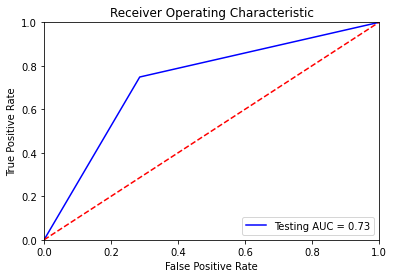

In [48]:
#ROC Curve

#test data ROC
fpr_ts, tpr_ts, threshold = roc_curve(y_test, y_pred)
roc_auc_test = auc(fpr_ts, tpr_ts)

#Plot ROC curve
plt.title('Receiver Operating Characteristic')
plt.plot(fpr_ts, tpr_ts, 'b', label = 'Testing AUC = %0.2f' % roc_auc_test)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [49]:
#Do Precision, F1 and Recall scores

#baseline model
print("Baseline Model Metrics")
print("Precision score:",precision_score(y_val, y_pred_val , average="macro"))
print("Recall score:",recall_score(y_val, y_pred_val , average="macro"))
print("F1 score:",f1_score(y_val, y_pred_val , average="macro"))

#tuned model
print("Tuned model metrics")
print("Precision score:",precision_score(y_test, y_pred , average="macro"))
print("Recall score:",recall_score(y_test, y_pred , average="macro"))
print("F1 score:",f1_score(y_test, y_pred , average="macro"))

Baseline Model Metrics
Precision score: 0.7140661201211905
Recall score: 0.7141042780748663
F1 score: 0.7138943335709194
Tuned model metrics
Precision score: 0.731789015041675
Recall score: 0.7314671814671815
F1 score: 0.7314635808693941


Baseline model metrics:
Precision score: .7141
Recall: .7141
F1: .8139

Best model metrics:
Precision: .7318
Recall: .7315
F1: .7315

In [50]:
#Confusion Matrix

confusion_matrix(y_test, y_pred)

array([[260, 104],
       [ 93, 277]])

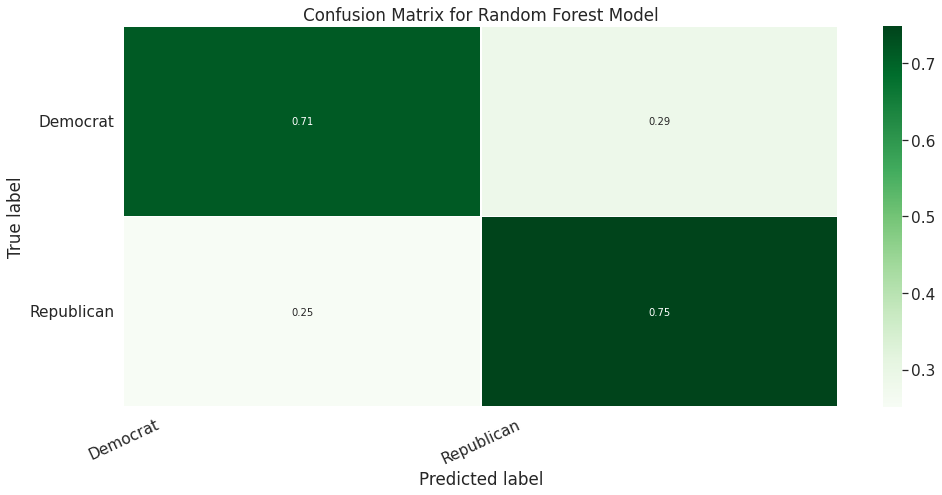

In [51]:
# Heatmap Confusion Matrix
import seaborn as sns
matrix = confusion_matrix(y_test, y_pred)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = ['Democrat', 'Republican']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()